In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Splitting the Data

In [2]:
#Loading the dataset
housing = fetch_california_housing()

In [3]:
#Creating training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target)

In [4]:
#Creating training and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

In [5]:
#Normalizing the training, validation and testing features using Standard Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

# Creating Dynamic Regression Model using Subclassing API

In [6]:
#Creating a class for the Dynamic Regression Model using Model as a Base Class
class WideAndDeepModel(keras.Model):

  #Initializing all the layers for the Deep and Wide NN model
  def __init__(self, units=30, activation="relu", **kwargs):
    super().__init__(**kwargs) #To handle the additional keywords provided for Model class
    self.hidden1 = keras.layers.Dense(units=units, activation=activation)
    self.hidden2 = keras.layers.Dense(units=units, activation=activation)
    self.main_output = keras.layers.Dense(1)
    self.aux_output = keras.layers.Dense(1)

  #Defining the call method to implement the Network's forwardfeeding
  def call(self, inputs):
    input_A, input_B = inputs
    hidden1 = self.hidden1(input_B)
    hidden2 = self.hidden2(hidden1)
    concat = keras.layers.concatenate([input_A, hidden2])
    main_output = self.main_output(concat)
    aux_output = self.aux_output(hidden2)
    return main_output, aux_output

In [13]:
#Calling the class to create the Model
model = WideAndDeepModel()

In [14]:
#Creating input layers for the model
input_A = keras.layers.Input(shape=[5], name="wide-input") #Creating input features for wide path
input_B = keras.layers.Input(shape=[6], name="deep-input") #Creating input features for deep path

In [17]:
#Calling the call method to create the model for the input layers provided
main_output, aux_output = model.call((input_A, input_B))

# Compiling the Model

In [19]:
#Compiling the prepared model
model.compile(loss=["mse","mse"],
              optimizer=keras.optimizers.SGD(learning_rate=0.001),
              loss_weights=[0.9,0.1] #Assigning weightage for main and auxilary outputs
)

# Fiting Model on the Training Set

In [20]:
#Creating training, testing and validation sets for deep and wide paths
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [21]:
#Training the model (Added two times y_labels as there are 2 outputs)
history = model.fit((X_train_A, X_train_B), [y_train, y_train], epochs=20, validation_data=((X_valid_A, X_valid_B), [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 4.1201 - output_1_loss: 3.9732 - output_2_loss: 5.4423 - val_loss: 1.3880 - val_output_1_loss: 1.0576 - val_output_2_loss: 4.3619
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 1.3490 - output_1_loss: 1.0366 - output_2_loss: 4.1608 - val_loss: 1.0399 - val_output_1_loss: 0.8050 - val_output_2_loss: 3.1538
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9920 - output_1_loss: 0.7683 - output_2_loss: 3.0053 - val_loss: 0.9237 - val_output_1_loss: 0.7519 - val_output_2_loss: 2.4702
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8912 - output_1_loss: 0.7203 - output_2_loss: 2.4296 - val_loss: 0.8524 - val_output_1_loss: 0.7155 - val_output_2_loss: 2.0850
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8193 - output_1_loss: 0.6806 - output_2_loss: 2.0673 - val_loss: 0.7970 - val_output_1_loss: 0.6806 - val_ou

In [22]:
#Viewing the parameters for the model
history.params

{'epochs': 20, 'steps': 363, 'verbose': 1}

# Plotting the Model

In [23]:
#Using pandas dataframe to create a dataframe of the losses and extra parameters
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,output_1_loss,output_2_loss,val_loss,val_output_1_loss,val_output_2_loss
0,2.804544,2.544903,5.141318,1.388006,1.057575,4.361890
1,1.217114,0.932315,3.780309,1.039915,0.805044,3.153754
2,0.977932,0.772654,2.825430,0.923738,0.751907,2.470223
3,0.871854,0.713878,2.293642,0.852408,0.715454,2.084995
4,0.804402,0.673906,1.978872,0.797040,0.680637,1.844669


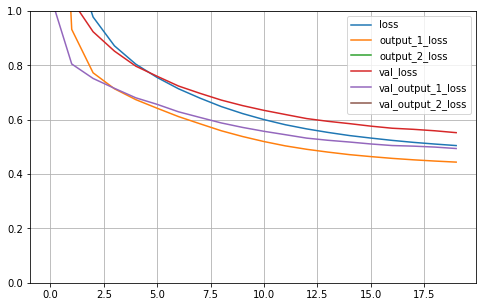

In [24]:
#Visualizing the learning curve for the model
history_df.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Evaluating the Model

In [25]:
#Evaluating Model for the test set
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), [y_test, y_test])

162/162 [==============================] - 0s 998us/step - loss: 0.5264 - output_1_loss: 0.4640 - output_2_loss: 1.0882


# Predicting New Values for Model

In [26]:
#Computing probabilities for the new set
y_proba_main, y_proba_aux = model.predict((X_new_A, X_new_B))
y_proba_main.round(2), y_proba_aux.round(2)

(array([[2.53],
        [1.68],
        [1.85]], dtype=float32), array([[2.16],
        [2.01],
        [1.87]], dtype=float32))